In [1]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print
from scipy.optimize import minimize
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

%load_ext rich

In [2]:
## Load the data
data = pd.read_csv("advertising.csv").rename(columns={"Unnamed: 0": "id"})
data

,id,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [3]:
X = data[["TV", "Radio", "Newspaper"]].values
y = data["Sales"].values

### Problem 1

The optimization problem for a linear regression using L1 loss is given by:
$$
\begin{align*}
\min & &  \sum_{i=1}^n f_i \\
\text{subject to }& \\ 
& & f_i \geq y_i - \sum_{j=1}^p x_{ij} \beta_j \\
& & f_i \geq - (y_i - \sum_{j=1}^p x_{ij} \beta_j)
\end{align*}
$$

In [4]:
# Gurobi implementation
def l1_loss_regression(X, y, fit_intercept=True):
    if fit_intercept:
        X = np.hstack((np.ones((X.shape[0], 1)), X))

    l1_regression = gp.Model("Linear Regression with L1 Loss")
    l1_regression.Params.LogToConsole = 0

    # Decision Variables
    betas = l1_regression.addVars(X.shape[1], name="beta", vtype=gp.GRB.CONTINUOUS)
    residuals = y - gp.quicksum(betas[i] * X[:, i] for i in range(X.shape[1]))

    residuals_ = l1_regression.addVars(
        X.shape[0], name="residuals", vtype=gp.GRB.CONTINUOUS
    )

    # Objective function
    l1_regression.setObjective(
        gp.quicksum(residuals_[i] for i in range(X.shape[0])), sense=gp.GRB.MINIMIZE
    )

    # Constraints
    l1_regression.addConstrs(
        (residuals_[i] >= residuals[i] for i in range(X.shape[0])),
        name="Residuals (positive)",
    )

    l1_regression.addConstrs(
        (residuals_[i] >= -residuals[i] for i in range(X.shape[0])),
        name="Residuals (negative)",
    )

    # Optimize
    l1_regression.optimize()

    # Print the solution
    coefficients = [betas[i].x for i in range(X.shape[1])]

    print(f"Coefficients: {coefficients}")
    print(f"Optimal objective value: {l1_regression.objVal:.3f}")

    return coefficients


print("-" * 80)
print("Gurobi implementation")
gurobi_results = l1_loss_regression(X, y)
print("-" * 80)


--------------------------------------------------------------------------------

Gurobi implementation

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-30


Coefficients: [3.2797893774713356, 0.04382140799173407, 0.1967413118206927, 0.0]

Optimal objective value: 242.512

--------------------------------------------------------------------------------

In [5]:
def scipy_l1_loss(X, y, fit_intercept=True):
    def fit(X, params):
        return X.dot(params)

    def loss(params, X, y):
        return np.sum(np.abs(y - fit(X, params)))

    if fit_intercept:
        X = np.hstack((np.ones((X.shape[0], 1)), X))

    output = minimize(loss, np.zeros(X.shape[1]), args=(X, y))
    print(f"Coefficients: {output.x}")
    print(f"Optimal objective value: {output.fun:.3f}")

    return output


print("-" * 80)
print("Scipy implementation")
scipy_output = scipy_l1_loss(X, y, fit_intercept=True)
print("-" * 80)


--------------------------------------------------------------------------------

Scipy implementation

Coefficients: [ 3.35463903e+00  4.37812997e-02  1.97058882e-01 -2.92941368e-03]

Optimal objective value: 242.209

--------------------------------------------------------------------------------

In [6]:
l2_regression = LinearRegression().fit(X, y)

print("-" * 80)
print("L2 Loss Function")
print(f"Coefficients: {np.hstack((l2_regression.intercept_, l2_regression.coef_))}")
print(f"Optimal objective value: {np.sum((y - l2_regression.predict(X)) ** 2):.3f}")
print("-" * 80)


--------------------------------------------------------------------------------

L2 Loss Function

Coefficients: [ 2.93888937e+00  4.57646455e-02  1.88530017e-01 -1.03749304e-03]

Optimal objective value: 556.825

--------------------------------------------------------------------------------

Comparing the L2 loss estimates to the L1 loss estimates, we see that the L1 loss estimates are more robust to outliers. The L1 loss estimates are $[3.28, 0.04, 0.19, 0.0]$, while the L2 loss estimates are $[2.93,  0.045,  0.188, -0.001]$.

In [7]:
assert np.allclose(gurobi_results, scipy_output.x, atol=1e-1)

### Problem 2

In [8]:
X_syn, y_syn = make_blobs(n_samples=500, n_features=2, centers=2, random_state=420)

y_syn[y_syn == 0] = -1  # Converting the labels to -1 and 1

X_syn, y_syn



(
    array([[-5.28245138e+00, -7.25815249e+00],
       [-3.02755481e+00, -8.40600356e+00],
       [-4.15371302e+00, -7.92815023e+00],
       [-4.66755173e+00, -1.41433674e+00],
       [-3.31665559e+00, -8.26820403e+00],
       [-3.67685008e+00, -6.60387582e+00],
       [-4.25254425e+00, -2.31773176e-01],
       [-2.69056633e+00, -6.07586828e+00],
       [-5.99197680e+00, -8.38919511e+00],
       [-5.26352953e+00, -6.81049716e+00],
       [-5.48725005e+00, -7.68592050e+00],
       [-4.49581086e+00, -2.36777303e+00],
       [-2.85261879e+00, -1.02715140e+00],
       [-2.78153382e+00, -2.63729416e+00],
       [-2.10054732e+00, -1.04619239e+00],
       [-5.66675099e+00, -7.15198952e+00],
       [-4.85897565e+00, -7.52803929e+00],
       [-5.03761458e+00, -1.93808900e+00],
       [-2.90157242e+00, -7.87888154e+00],
       [-3.69869624e+00, -8.06504857e+00],
       [-4.01363041e+00, -9.41271183e-01],
       [-1.94574490e+00, -1.10988384e+00],
       [-4.69318100e+00, -1.07207707e+00],
    

#### Visualize the data

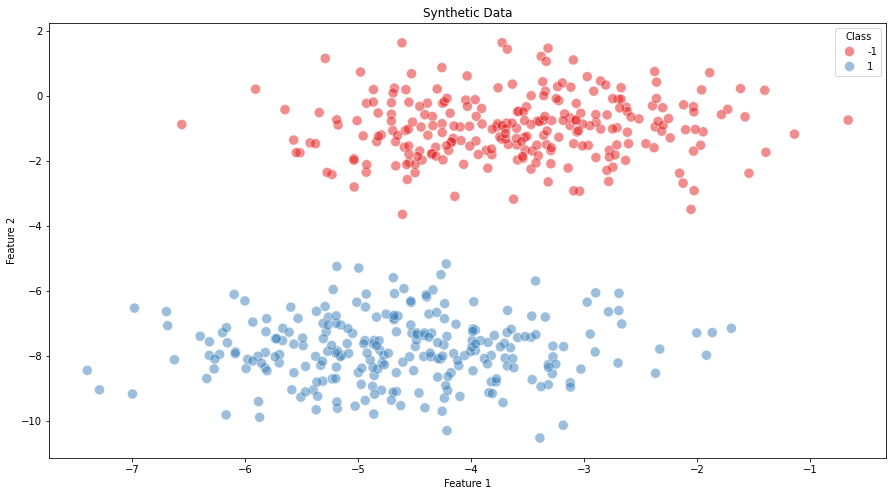

In [9]:
plt.figure(figsize=(15, 8))

scatter = sns.scatterplot(
    x=X_syn[:, 0], y=X_syn[:, 1], hue=y_syn, s=100, palette="Set1", alpha=0.5
)

plt.title("Synthetic Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Class")

plt.show()


The data is linearly separable as the red and blue points can clearly be separated by a line.

#### Linear classifier in Gurobi

$$
\begin{align*}
\max & & \epsilon \\
\text{subject to }& \\
& & y_i (w X_i + b) \geq \epsilon \\
& & -\infty \leq w \leq \infty \\
& & -\infty \leq b \leq \infty \\
& & 1^{-10} \leq \epsilon \leq 1
\end{align*}
$$

In [15]:
linear_classifer = gp.Model("Linear Classifier")

# Decision Variables
weights = linear_classifer.addVars(
    X_syn.shape[1],
    name="weights",
    vtype=gp.GRB.CONTINUOUS,
    lb=-gp.GRB.INFINITY,
    ub=gp.GRB.INFINITY,
)

bias = linear_classifer.addVar(
    name="bias", vtype=gp.GRB.CONTINUOUS, lb=-gp.GRB.INFINITY, ub=gp.GRB.INFINITY
)

epsilon = linear_classifer.addVar(
    name="epsilon", vtype=gp.GRB.CONTINUOUS, lb=1e-10, ub=1
)  # The margin is bounded to prevent numerical issues

# Objective function
linear_classifer.setObjective(epsilon, sense=gp.GRB.MAXIMIZE)

# Constraints
classified_values = [
    gp.quicksum(weights[j] * X_syn[i, j] for j in range(X_syn.shape[1])) + bias
    for i in range(X_syn.shape[0])
]

linear_classifer.addConstrs(
    (y_syn[i] * classified_values[i] >= epsilon for i in range(X_syn.shape[0]))
)

# Optimize
linear_classifer.update()
linear_classifer.optimize()

# Print the solution
print(f"Optimal objective value: {linear_classifer.objVal:}")
print(f"Optimal weights: {[weights[i].x for i in range(X_syn.shape[1])]}")
print(f"Optimal bias: {bias.x}")


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 500 rows, 4 columns and 2000 nonzeros
Model fingerprint: 0x94d568d9
Coefficient statistics:
  Matrix range     [5e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-10, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.02s
Presolved: 500 rows, 4 columns, 2000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      10    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.000000000e+00


Optimal objective value: 1.0

Optimal weights: [0.07785404193488532, -1.295270292430094]

Optimal bias: -5.370009844236689

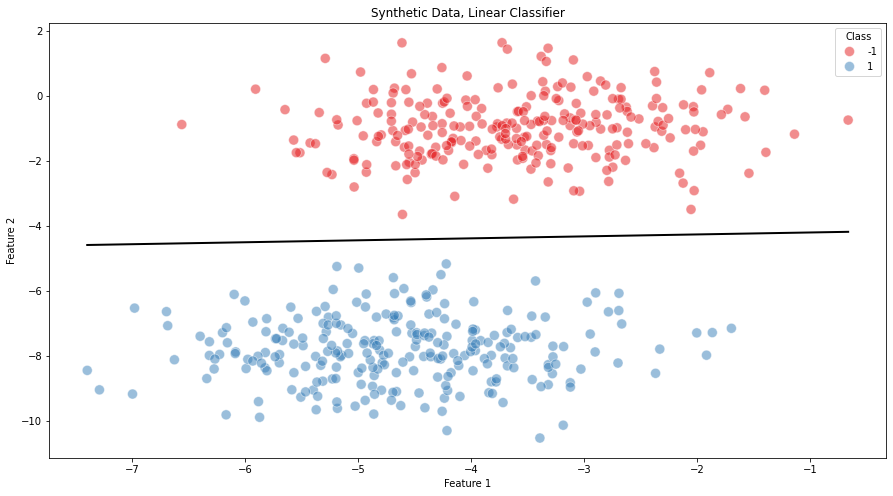

In [11]:
# Plot the decision boundary
plt.figure(figsize=(15, 8))

scatter = sns.scatterplot(
    x=X_syn[:, 0], y=X_syn[:, 1], hue=y_syn, s=100, palette="Set1", alpha=0.5
)

x1 = np.linspace(np.min(X_syn[:, 0]), np.max(X_syn[:, 0]), 100)
x2 = -(weights[0].x * x1 + bias.x) / weights[1].x

plt.plot(x1, x2, color="black", linewidth=2)

plt.title("Synthetic Data, Linear Classifier")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Class")

plt.show()


As we can see, the plotted boundary line clearly separates the points. Therefore, the generated dataset can be classified using a linear classifier. We now compare the results from the optimization formulation to using the SVM classifier from `scikit-learn`.

#### Using SVC from scikit-learn

In [12]:
clf = SVC(kernel="linear", C=1)
clf.fit(X_syn, y_syn)

# Print weights and bias
print(f"Optimal weights: {clf.coef_}")
print(f"Optimal bias: {clf.intercept_}")

Optimal weights: [[ 0.07786545 -1.2954419 ]]

Optimal bias: [-5.37067243]

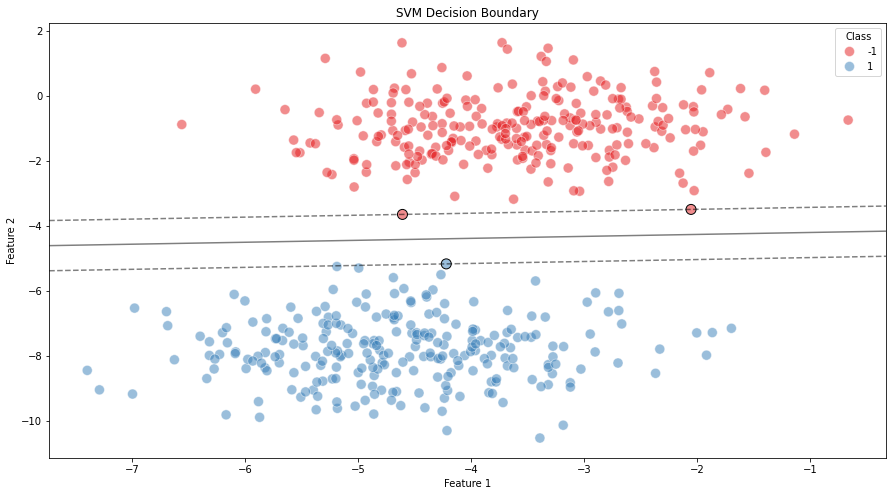

In [13]:
# Visualize the decision boundary
plt.figure(figsize=(15, 8))
plt.clf()
sns.scatterplot(
    x=X_syn[:, 0], y=X_syn[:, 1], hue=y_syn, s=100, palette="Set1", alpha=0.5
)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)

xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = clf.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# Plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

plt.title("SVM Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Class")

plt.show()


The coefficients and the bias term obtained from the SVM classifier are quite close to those obtained from the optimization formulation.